Creating the Initial Conditions for our BH/DM Halo Simulation!

In [1]:
import scipy.stats as st
import numpy as np
import random

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from math import isnan
#from math import gamma
from scipy.special import gamma
from astropy import units as u
from astropy import constants as c

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
"""Edited to respect notational conventions"""
G = c.G
U_ENERGY = u.solMass * u.parsec**2 * u.s**-2
M_IMBH = 1e4 * u.solMass
RHO_SP = 226. * u.solMass / u.parsec**3
GAMMA_SP = 2.25  # Dimensionless slope parameter.
R_IN = 1.914e-9 * u.parsec
R_SP = 1.17097 * u.parsec
N_PARTICLES = 2**16

In [3]:
"""Sampling from 1d distributions"""
def sample_cdf(pdf, xmin, xmax, n_bins=1000, log=False):
    if log:
        binner = np.geomspace
    else:
        binner = np.linspace
    edges = binner(xmin, xmax, n_bins)
    bins = np.vstack((edges[:-1], edges[1:])).T
    centers = np.mean(bins, axis=1)
    widths = bins[:, 1] - bins[:, 0]
    pdf_samples = pdf(centers)
    cdf_samples = np.cumsum(pdf_samples * widths)
    cdf_samples /= cdf_samples[-1]
    return np.vstack((centers, cdf_samples)).T

def inverse_cdf(*args, **kwargs):
    iy, ix = sample_cdf(*args, **kwargs).T
    return interp1d(ix, iy, fill_value='extrapolate')

def sample_icdf(icdf, n_samples):
    range_samples = np.random.uniform(size=n_samples)
    return icdf(range_samples)

def sample(pdf, xmin, xmax, n_samples, **kwargs):
    icdf = inverse_cdf(pdf, xmin, xmax, **kwargs)
    return sample_icdf(icdf, n_samples)

In [4]:
def radius_pdf(r):
    # Takes dimensionless r in pc
    rho_dm = RHO_SP.to(u.solMass / u.pc**3).value * \
        (R_SP.to(u.pc).value/r)**GAMMA_SP
    return rho_dm * r**2

CPU times: user 15.1 s, sys: 13.9 s, total: 29 s
Wall time: 38.6 s


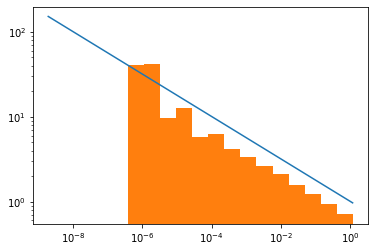

In [5]:
%%time
radius = sample(radius_pdf, R_IN/u.pc, R_SP/u.pc, N_PARTICLES, n_bins=int(1e8), log=True)
plt.loglog()
r_values = np.geomspace(R_IN/u.pc, R_SP/u.pc, 20)
p_values = radius_pdf(r_values)
plt.plot(r_values, p_values / 320)
plt.hist(radius, density=True, bins=r_values);

In [6]:
def random_unit_vector(n_samples):
    vector = np.random.normal(size=3*n_samples).reshape((n_samples, 3))
    return vector / np.linalg.norm(vector, axis=1)[:, np.newaxis]

In [7]:
%%time
unit_vectors = random_unit_vector(len(radius))

CPU times: user 10.1 ms, sys: 2.02 ms, total: 12.2 ms
Wall time: 12.2 ms


In [8]:
%%time
positions = radius[:, np.newaxis] * unit_vectors

CPU times: user 1.17 ms, sys: 459 µs, total: 1.63 ms
Wall time: 1.19 ms


CPU times: user 42.1 ms, sys: 7.06 ms, total: 49.1 ms
Wall time: 38.1 ms


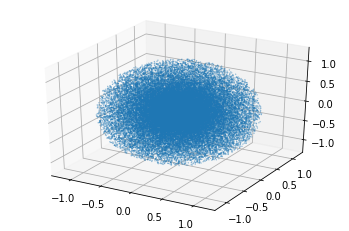

In [9]:
%%time
ax = plt.axes(projection='3d')
ax.scatter3D(*positions.T, s=0.1);

Let's randomize the velocities of each DM particle! See eq. (S5) of [1905.04686](https://arxiv.org/pdf/1905.04686.pdf).

In [10]:
def fvr(v, r):
    # Dimensionless inputs and outputs
    vmax = np.sqrt(2 * G * M_IMBH / r).to(u.pc**(3./2.) / u.s).value
    return 4 / np.sqrt(np.pi) * gamma(GAMMA_SP+1) / gamma(GAMMA_SP-1./2.) * \
        v**2 / vmax**(2*GAMMA_SP) * (vmax**2 - v**2) ** (GAMMA_SP - 3./2.)

Sample from this distribution separately for each $r$ value:

In [11]:
%%time
speed = np.zeros_like(radius)
for i, r in enumerate(radius):
    vmax = np.sqrt(2 * G * M_IMBH / (r*u.pc)).to(u.pc / u.s).value
    v_pdf = lambda v: fvr(v, r)
    speed[i] = sample(v_pdf, 0, vmax, 1)

CPU times: user 52.8 s, sys: 266 ms, total: 53.1 s
Wall time: 54.2 s


Now give these velocities random directions:

In [12]:
%%time
unit_vectors = random_unit_vector(len(speed))
velocities = speed[:, np.newaxis] * unit_vectors

CPU times: user 9.83 ms, sys: 1.66 ms, total: 11.5 ms
Wall time: 10 ms


Now we have position and velocity arrays:

In [13]:
positions

array([[-0.17791717, -0.08992101, -0.02497932],
       [ 0.01257864,  0.01768989, -0.03128018],
       [-0.02171726, -0.01908448,  0.03897397],
       ...,
       [ 0.42553375,  0.45440797,  0.71604575],
       [-0.07401978,  0.12738498, -0.05401064],
       [-0.02302472, -0.31685638,  0.09117113]])

In [14]:
velocities

array([[-1.64997803e-13,  3.93074913e-13,  3.84780929e-13],
       [-3.77762210e-13,  4.51083896e-13,  1.50959906e-13],
       [ 8.20093315e-13,  5.96621510e-13, -3.00055143e-14],
       ...,
       [-1.45791166e-13, -2.22203894e-15,  1.20789155e-14],
       [-1.25107926e-13, -1.80379316e-14, -2.12327004e-13],
       [-1.34177596e-13,  3.64451063e-13, -3.67179032e-14]])

Note that for no particular reason, the units are parsecs and _seconds_. This is why the velocities look so low. If we were to convert them to km/s, we would get:

In [15]:
(velocities * u.pc / u.s).to(u.km / u.s).value

array([[ -5.09130022,  12.12902448,  11.87309885],
       [-11.65652383,  13.91899467,   4.65813597],
       [ 25.30543557,  18.40981617,  -0.92587343],
       ...,
       [ -4.49864532,  -0.06856496,   0.37271639],
       [ -3.86042723,  -0.55659241,  -6.55172676],
       [ -4.14028801,  11.24578475,  -1.13299611]])